In [1]:
from typing import Tuple, List, Dict, Union
import os
from pathlib import Path
import glob
import gc
import random
from datetime import datetime

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import geojson
from patchify import patchify
import cv2


from extract_patches import create_bbox_list, get_annotated_rois, create_masks

OPENSLIDE_PATH  = r'C:/openslide/openslide-win64/bin'
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [2]:
DATA_PATH = '/mnt/d/UCL-HDS-DissertationDataset/BRACS/BRACS_WSI'
ANNOT_PATH = '/mnt/c/UCL-HDS-DissertationDataset/BRACS_WSI_Annotations'
PATCH_PATH = './data/patches'

In [4]:
slide = openslide.OpenSlide(f'{DATA_PATH}/train/Group_AT/Type_ADH/BRACS_1486.svs')

print("levels:", slide.level_count)
print("level dimensions", slide.level_dimensions)
print("level downsamples", slide.level_downsamples)

# get annotations
annotation_file = f'{ANNOT_PATH}/train/Group_AT/Type_ADH/BRACS_1486.geojson'
annotations = geojson.load(open(annotation_file))
bbox_list = create_bbox_list(annotations)
rois = get_annotated_rois(slide, bbox_list)
masks = create_masks(annotations)

roi_bboxes = np.array(list(map(lambda x: x["coordinates"], bbox_list)))

thumbnail_arr = np.array(slide.get_thumbnail(slide.level_dimensions[-1]))
slide_width, slide_height = slide.dimensions
height, width = thumbnail_arr.shape[:2]
width_ratio =  width / slide_width
height_ratio = height / slide_height

scaled_roi_bboxes = roi_bboxes * np.array([width_ratio, height_ratio])

thumbnail_plot_arr = thumbnail_arr.copy()

for scaled_roi_bbox in scaled_roi_bboxes:
    print(f"scaled roi bbox: {scaled_roi_bbox}")
    min_coord, max_coord = scaled_roi_bbox
    cv2.rectangle(
        thumbnail_plot_arr,
        min_coord.astype(int),
        max_coord.astype(int),
        (0, 0, 0),
        2
    )

levels: 4
level dimensions ((147408, 88478), (36852, 22119), (9213, 5529), (2303, 1382))
level downsamples (1.0, 4.000045210000453, 16.001266051727256, 64.01432756493921)
scaled roi bbox: [[1226.60122246  478.38461538]
 [1257.11353522  507.8746129 ]]
scaled roi bbox: [[1866.37552236  730.9395782 ]
 [1896.68473217  754.94706029]]
scaled roi bbox: [[1476.9959161   833.15490856]
 [1535.14585369  894.27480278]]
scaled roi bbox: [[1756.79366791  777.34571306]
 [1776.08844839  798.88528222]]
scaled roi bbox: [[1721.71935037 1021.32545944]
 [1796.16439406 1076.22871222]]
scaled roi bbox: [[1715.2044326  1066.04466647]
 [1759.0746703  1106.2185402 ]]
scaled roi bbox: [[1770.40156572 1072.54246253]
 [1817.6620604  1117.5428242 ]]
scaled roi bbox: [[1699.64362178 1106.78084948]
 [1742.09213883 1144.98664075]]
scaled roi bbox: [[1762.76177005 1118.38628812]
 [1799.55465104 1146.97034291]]
scaled roi bbox: [[1766.4488698   545.22132055]
 [1822.14594866  588.23798006]]
scaled roi bbox: [[1808.72553

1177 428 1945 1196


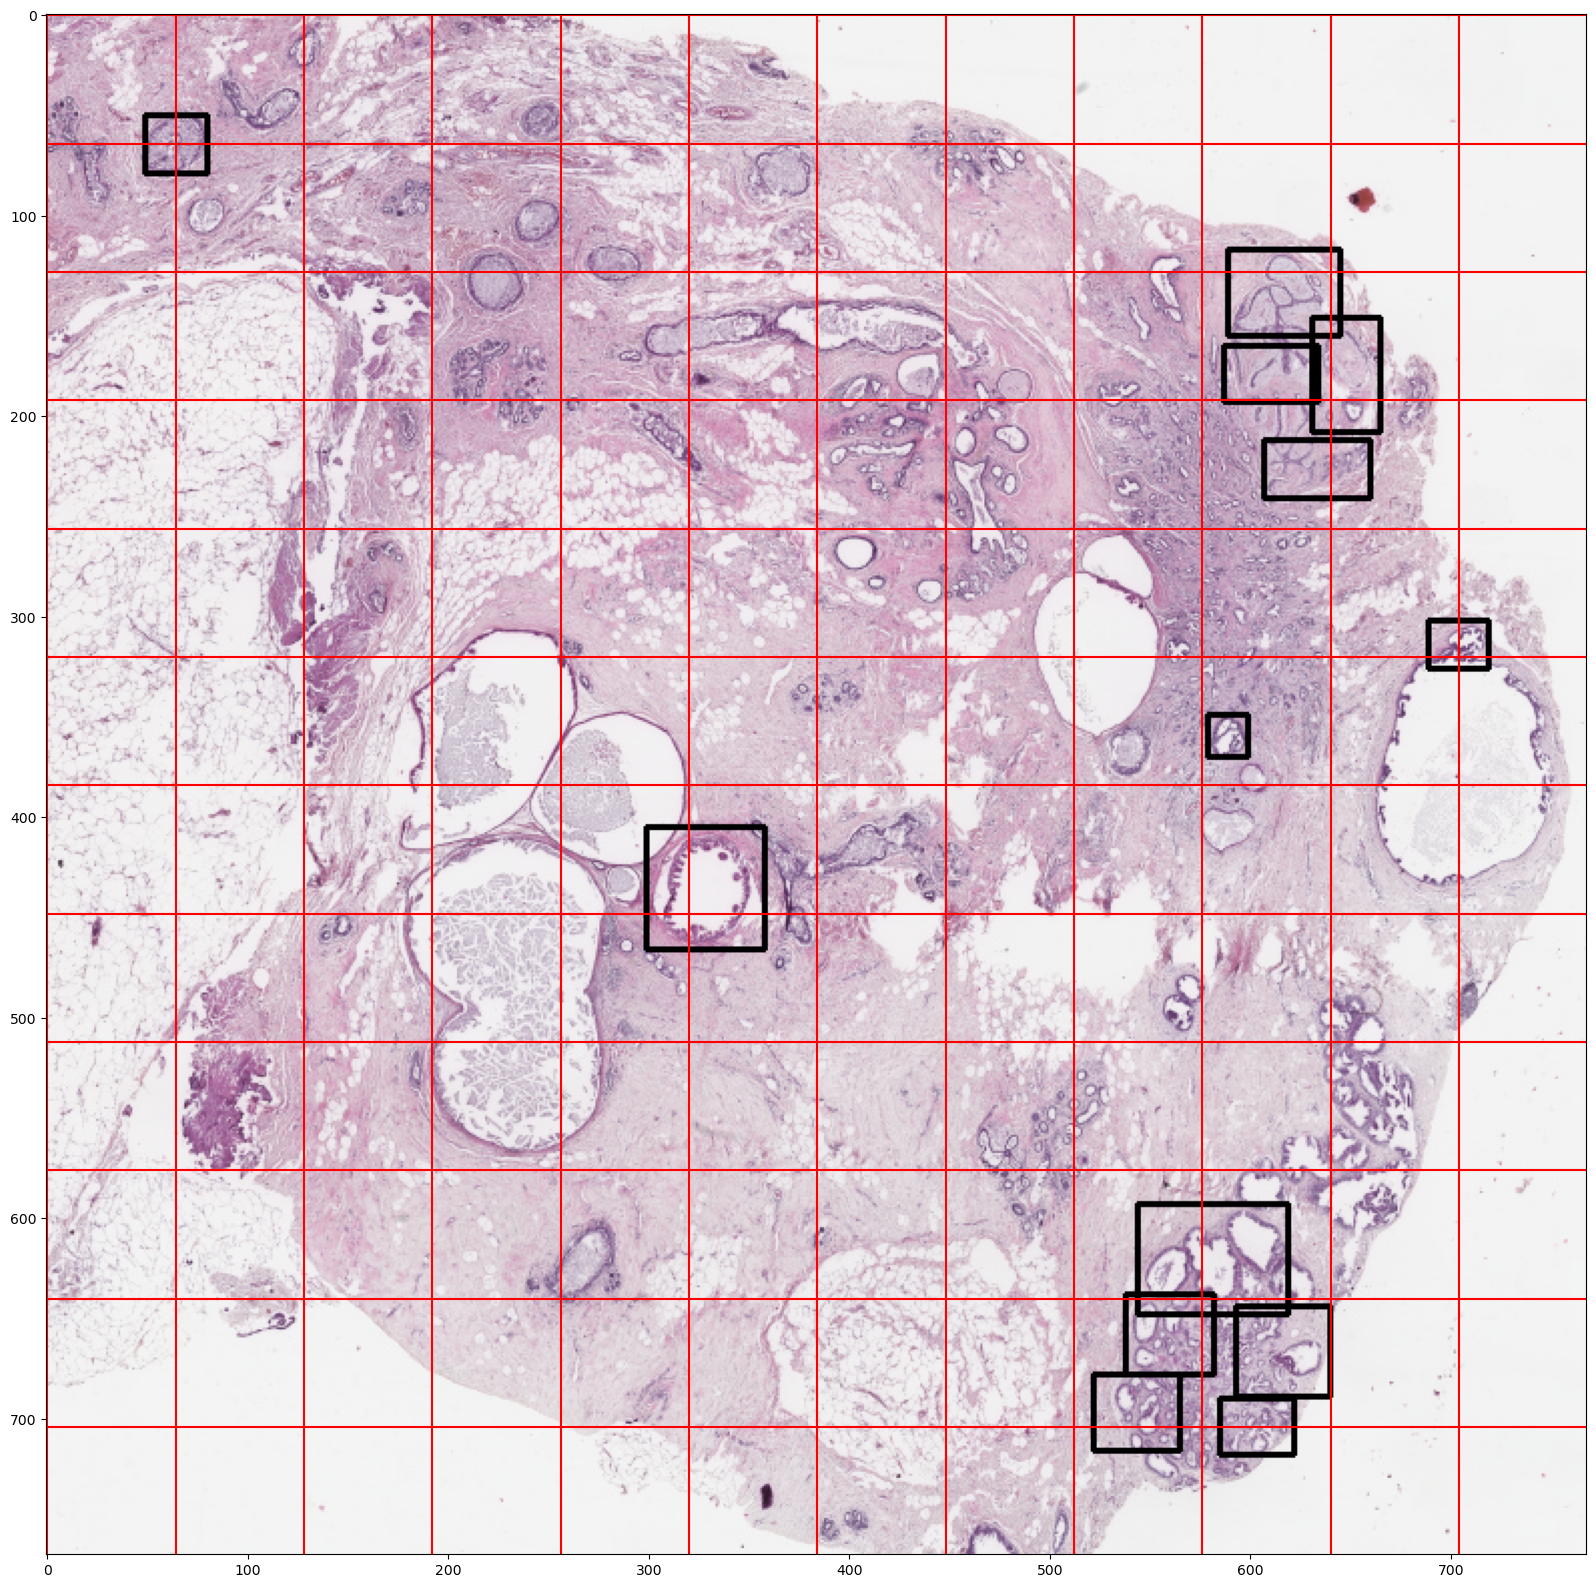

In [5]:
PATCH_SIZE = 256
STEP_SIZE = 64

# get the min and max x and y coordinates among the ROIs
min_bbox_x, min_bbox_y = scaled_roi_bboxes.reshape(-1, 2).min(axis=0).astype(int)
max_bbox_x, max_bbox_y = scaled_roi_bboxes.reshape(-1, 2).max(axis=0).astype(int)

# extend the min and max coordinates value to create the slide extraction area

# first, add 30 pixel padding to the min and max coordinates
# check if the the points are within the bounds of thumbnail
extract_min_x = max(0, min_bbox_x - 30)
extract_min_y = max(0, min_bbox_y - 30)
extract_max_x = min(width, max_bbox_x + 30)
extract_max_y = min(height, max_bbox_y + 30)

# second, extend min and max coordinates such that the width and height are divisible by 256
extract_width = extract_max_x - extract_min_x
extract_height = extract_max_y - extract_min_y

add_to_left = True
while extract_width % PATCH_SIZE != 0:
    # randomly add 1 pixel to the left or right side of the image
    if add_to_left:
        extract_min_x = max(0, extract_min_x - 1)
        add_to_left = False
    else:
        extract_max_x = min(width, extract_max_x + 1)
        add_to_left = True
    extract_width = extract_max_x - extract_min_x

add_to_top = True
while extract_height % PATCH_SIZE != 0:
    # randomly add 1 pixel to the top or bottom side of the image
    if add_to_top:
        extract_min_y = max(0, extract_min_y - 1)
        add_to_top = False
    else:
        extract_max_y = min(height, extract_max_y + 1)
        add_to_top = True
    extract_height = extract_max_y - extract_min_y

print(extract_min_x, extract_min_y, extract_max_x, extract_max_y)

fig = plt.figure(figsize=(20, 20))
plt.imshow(thumbnail_plot_arr[extract_min_y:extract_max_y, extract_min_x:extract_max_x, :])
# draw lines at 256 pixel intervals vertically and horizontally to indictate the 256x256 patches
for i in range(0, extract_width, 64):
    plt.axvline(i, color='r')
for i in range(0, extract_height, 64):
    plt.axhline(i, color='r')

plt.show()

In [6]:
extract_area_arr = thumbnail_arr[extract_min_y:extract_max_y, extract_min_x:extract_max_x, :]

In [7]:
# patchify the slide image, each patch is 512x512, step is 256
slide_patches = patchify(extract_area_arr, (PATCH_SIZE, PATCH_SIZE, 3), step=STEP_SIZE)
slide_patches.shape

(9, 9, 1, 256, 256, 3)

In [8]:
# create a list of dict including patches and the corresponding list of roi in relative coordinates

patch_annots = []
for i in range(slide_patches.shape[0]):
        patch_annots_row = []
        for j in range(slide_patches.shape[1]):
            patch_annots_row.append({
                    'patch': slide_patches[i, j, 0],
                    'roi_bboxes': []
            })
        patch_annots.append(patch_annots_row)
        
(patch_annots[0][0]['patch'] == slide_patches[0, 0, ::]).all()

# retrieve relative coordinates of the bboxes in the patchified images
for scaled_roi_bbox in scaled_roi_bboxes:
    # print(scaled_roi_bbox)
    (min_x, min_y), (max_x, max_y) = scaled_roi_bbox
    
    # get the step index of the bbox
    min_x_step_idx = int((min_x - extract_min_x) // STEP_SIZE)
    min_y_step_idx = int((min_y - extract_min_y) // STEP_SIZE)
    max_x_step_idx = int((max_x - extract_min_x) // STEP_SIZE)
    max_y_step_idx = int((max_y - extract_min_y) // STEP_SIZE)
    # print(min_x_step_idx, min_y_step_idx, max_x_step_idx, max_y_step_idx)

    # compile a list of patches that the bbox is in, indicated by the patch indices
    patch_list: List[Tuple[int]] = []
    for x in range( # the range is computed by the step index of the bbox
        max(0, min_x_step_idx - PATCH_SIZE//STEP_SIZE + 1), # min patch x
        min(slide_patches.shape[1], max_x_step_idx + 1) # max patch x
    ):
        for y in range( # the range is computed by the step index of the bbox
            max(0, min_y_step_idx - PATCH_SIZE//STEP_SIZE + 1), # min patch y
            min(slide_patches.shape[0], max_y_step_idx + 1) # max patch y
        ):
            patch_list.append((y, x))

    # print(patch_list)

    for patch_idx in patch_list:
        # get the relative coordinates of the bbox in the patch
        patch_min_x = max(0, min_x - extract_min_x - patch_idx[1] * STEP_SIZE)
        patch_min_y = max(0, min_y - extract_min_y - patch_idx[0] * STEP_SIZE)
        patch_max_x = min(PATCH_SIZE, max_x - extract_min_x - patch_idx[1] * STEP_SIZE)
        patch_max_y = min(PATCH_SIZE, max_y - extract_min_y - patch_idx[0] * STEP_SIZE)
        # print(patch_min_x, patch_min_y, patch_max_x, patch_max_y)
        
        patch_annots[patch_idx[0]][patch_idx[1]]["roi_bboxes"].append(
            np.array([(patch_min_x, patch_min_y), (patch_max_x, patch_max_y)], dtype=int)
        )

In [9]:
patch_annots[1][8]['roi_bboxes']

[array([[177, 238],
        [207, 256]]),
 array([[ 77,  53],
        [133,  96]]),
 array([[119,  87],
        [153, 144]]),
 array([[ 75, 101],
        [122, 129]]),
 array([[ 95, 148],
        [148, 177]])]

In [10]:
# get a copy of the patch
sample_slide_patch_plot_arr = patch_annots[1][8]["patch"].copy()

# draw rectangle on the patch copy
for annot in patch_annots[1][8]["roi_bboxes"]:
    cv2.rectangle(
        sample_slide_patch_plot_arr,
        annot[0],
        annot[1],
        (0, 0, 0),
        2
    )

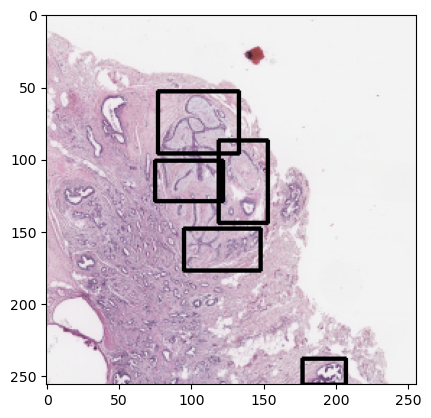

In [11]:
plt.imshow(sample_slide_patch_plot_arr)

In [12]:
THUMB_PATH = './data/thumbnails/'

In [ ]:
failed_file_path = Path(f'./logs/failed_slide_files-{datetime.now().strftime("%Y%m%d-%H%M%S")}.txt')

# get all annotations
train_set = glob.glob(f'{ANNOT_PATH}/train/**/*.geojson', recursive=True)
val_set = glob.glob(f'{ANNOT_PATH}/val/**/*.geojson', recursive=True)
test_set = glob.glob(f'{ANNOT_PATH}/test/**/*.geojson', recursive=True)

for train_annot_path in train_set:
    file_id = train_annot_path.split('/')[-1].split('.')[0]
    print('processing:', file_id)
    wsi_file_paths = glob.glob(f'{DATA_PATH}/train/**/{file_id}.svs', recursive=True)

    try:
        slide = openslide.OpenSlide(wsi_file_paths[0])
        Path(f'{THUMB_PATH}/train').mkdir(parents=True, exist_ok=True)
        slide.get_thumbnail(slide.level_dimensions[-1]).save(f'{THUMB_PATH}/train/{file_id}.png')
    except:
        failed_file_path.parent.mkdir(parents=True, exist_ok=True)
        with open(failed_file_path, 'a+') as f:
            f.write(f'{file_id}\n')
    finally:
        slide.close()
    gc.collect()

for val_annot_path in val_set:
    file_id = val_annot_path.split('/')[-1].split('.')[0]
    print('processing:', file_id)
    wsi_file_paths = glob.glob(f'{DATA_PATH}/val/**/{file_id}.svs', recursive=True)

    try:
        slide = openslide.OpenSlide(wsi_file_paths[0])
        Path(f'{THUMB_PATH}/val').mkdir(parents=True, exist_ok=True)
        slide.get_thumbnail(slide.level_dimensions[-1]).save(f'{THUMB_PATH}/val/{file_id}.png')
    except:
        failed_file_path.parent.mkdir(parents=True, exist_ok=True)
        with open(failed_file_path, 'a+') as f:
            f.write(f'{file_id}\n')
    finally:
        slide.close()
    gc.collect()

processing: BRACS_1003728
processing: BRACS_1486
processing: BRACS_1494
processing: BRACS_1499
processing: BRACS_1616
processing: BRACS_1622
processing: BRACS_1794
processing: BRACS_1795
processing: BRACS_1808
processing: BRACS_1860
processing: BRACS_1861
processing: BRACS_1863
processing: BRACS_1877
processing: BRACS_1882
processing: BRACS_1899
processing: BRACS_1911
processing: BRACS_1912
processing: BRACS_1913
processing: BRACS_1915
processing: BRACS_1922
processing: BRACS_1925
processing: BRACS_1932
processing: BRACS_1933
processing: BRACS_1934
processing: BRACS_1003693
processing: BRACS_1239
processing: BRACS_1250
processing: BRACS_1257
processing: BRACS_1319
processing: BRACS_1506
processing: BRACS_1510
processing: BRACS_1773
processing: BRACS_1774
processing: BRACS_1775
processing: BRACS_1777
processing: BRACS_1778
processing: BRACS_1788
processing: BRACS_1815
processing: BRACS_1838
processing: BRACS_1857
processing: BRACS_1858
processing: BRACS_1865
processing: BRACS_1871
proce